In [42]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from theano import shared
from IPython.core.display import HTML, display

In [2]:
%matplotlib inline
display(HTML("<style>.container {width:90% !important}</style>"))

In [125]:
def compare_plot(comp_df, ax=None):
    """
    Model comparison summary plot in the style of the one used in the book
    Statistical Rethinking by Richard McElreath.
    Parameters
    ----------
    comp_df: DataFrame
        The result of the pm.compare() function
    ax : axes
        Matplotlib axes. Defaults to None.
    Returns
    -------
    ax : matplotlib axes
    """
    if ax is None:
        _, ax = pl.subplots()

    yticks_pos, step = np.linspace(0, -1, (comp_df.shape[0] * 2) - 1, retstep=True)
    yticks_pos[1::2] = yticks_pos[1::2] + step / 2

    yticks_labels = [''] * len(yticks_pos)
    yticks_labels[0] = comp_df.index[0]
    yticks_labels[1::2] = comp_df.index[1:]

    data = comp_df.values
    min_ic = data[0, 0]

    ax.errorbar(x=data[:, 0], y=yticks_pos[::2], xerr=data[:, 4],
                fmt='ko', mfc='None', mew=1)
    ax.errorbar(x=data[1:, 0], y=yticks_pos[1::2],
                xerr=data[1:, 5], fmt='^', color='grey')

    ax.plot(data[:, 0] - (2 * data[:, 1]), yticks_pos[::2], 'ko')
    ax.axvline(min_ic, ls='--', color='grey')

    ax.set_yticks(yticks_pos)
    ax.set_yticklabels(yticks_labels)
    ax.set_xlabel('Deviance')
    lims=ax.get_ylim()
    ax.set_ylim(lims[0] + step/2., lims[1] - step/2.)
    return ax

In [3]:
dfNomadV2 = pd.read_pickle('./pickleJar/NOMADV2SWFClean.pkl')

In [4]:
dfNomadV2.head()

,id,depth,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,hplc_chl,fluo_chl,chl_all
0,1565,0.0,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,NaN,38.19,38.19
1,1566,0.0,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,NaN,35.01,35.01
2,1567,1.0,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,NaN,26.91,26.91
3,1568,3.0,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,NaN,47.96,47.96
4,1559,1.0,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,NaN,23.55,23.55


In [18]:
def GetFluoType(row):
    if np.isnan(row['hplc_chl']):
        return 'fluo'
    return 'hplc'

In [109]:
dfNomadV2['maxBlue'] = dfNomadV2.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555
dfLogOC4CI = pd.DataFrame(columns=['id', 'mxBl2Gr',  'CI', 'type', 'chl'])
dfLogOC4CI['id'] = dfNomadV2.id
dfLogOC4CI['mxBl2Gr'] = np.log10(dfNomadV2.blue2green)
dfLogOC4CI['type'] = dfNomadV2.apply(GetFluoType, axis=1)
dfLogOC4CI['CI'] = dfNomadV2.rrs555 - (dfNomadV2.rrs443 + (555 - 443) / (670 - 443) * (dfNomadV2.rrs670 - dfNomadV2.rrs443))
dfLogOC4CI['depth'] = dfNomadV2.depth
dfLogOC4CI['chl'] = np.log10(dfNomadV2.chl_all)

In [20]:
dfLogOC4CI.head()

,id,mxBl2Gr,CI,type,chl
0,1565,-0.267867,0.004916,fluo,1.581950
1,1566,-0.220457,0.002615,fluo,1.544192
2,1567,-0.268537,0.002850,fluo,1.429914
3,1568,-0.279976,0.004504,fluo,1.680879
4,1559,-0.167733,0.001399,fluo,1.371991


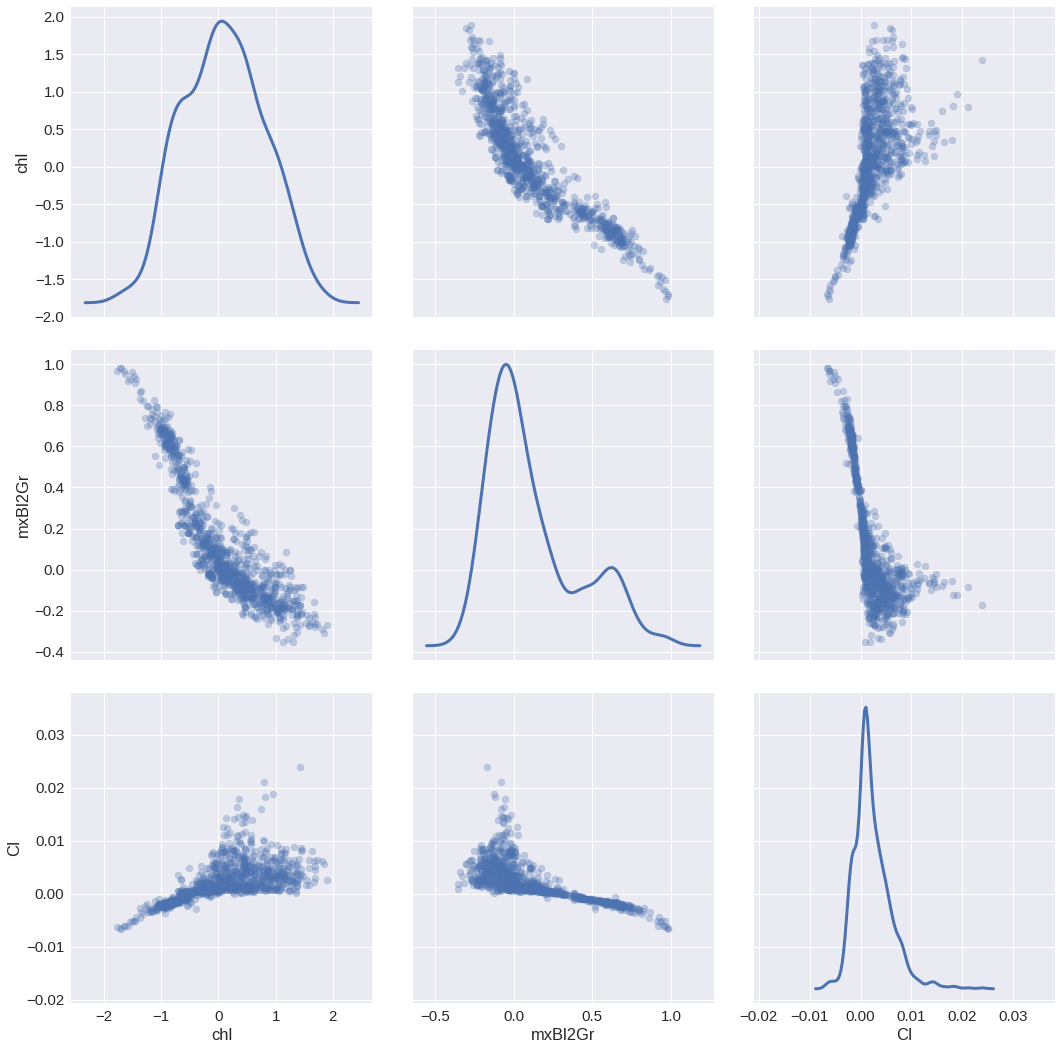

In [21]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOC4CI, vars=['chl', 'mxBl2Gr', 'CI'],size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.3)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(pl.scatter, alpha=0.3);

In [27]:
dfSortedLogOC4CI = dfLogOC4CI.sort_values('chl')

In [28]:
dfSortedLogOC4CI.head()

,id,mxBl2Gr,CI,type,chl
3919,7221,0.968712,-0.006214,hplc,-1.769551
3917,7219,0.980597,-0.006389,hplc,-1.721246
3916,7218,0.982648,-0.006578,hplc,-1.698970
3915,7217,0.965411,-0.006061,hplc,-1.657577
3920,7222,0.951725,-0.006118,hplc,-1.638272


In [29]:
dfSortedLogOC4CI.reset_index(inplace=True, drop=True)

In [43]:
ss = StandardScaler()

In [44]:
dfSortedLogOC4CI['CI_s'] = ss.fit_transform(dfSortedLogOC4CI.CI)

In [45]:
dfSortedLogOC4CI.head()

,id,mxBl2Gr,CI,type,chl,CI_s
0,7221,0.968712,-0.006214,hplc,-1.769551,-2.355436
1,7219,0.980597,-0.006389,hplc,-1.721246,-2.403987
2,7218,0.982648,-0.006578,hplc,-1.698970,-2.456637
3,7217,0.965411,-0.006061,hplc,-1.657577,-2.312652
4,7222,0.951725,-0.006118,hplc,-1.638272,-2.328556


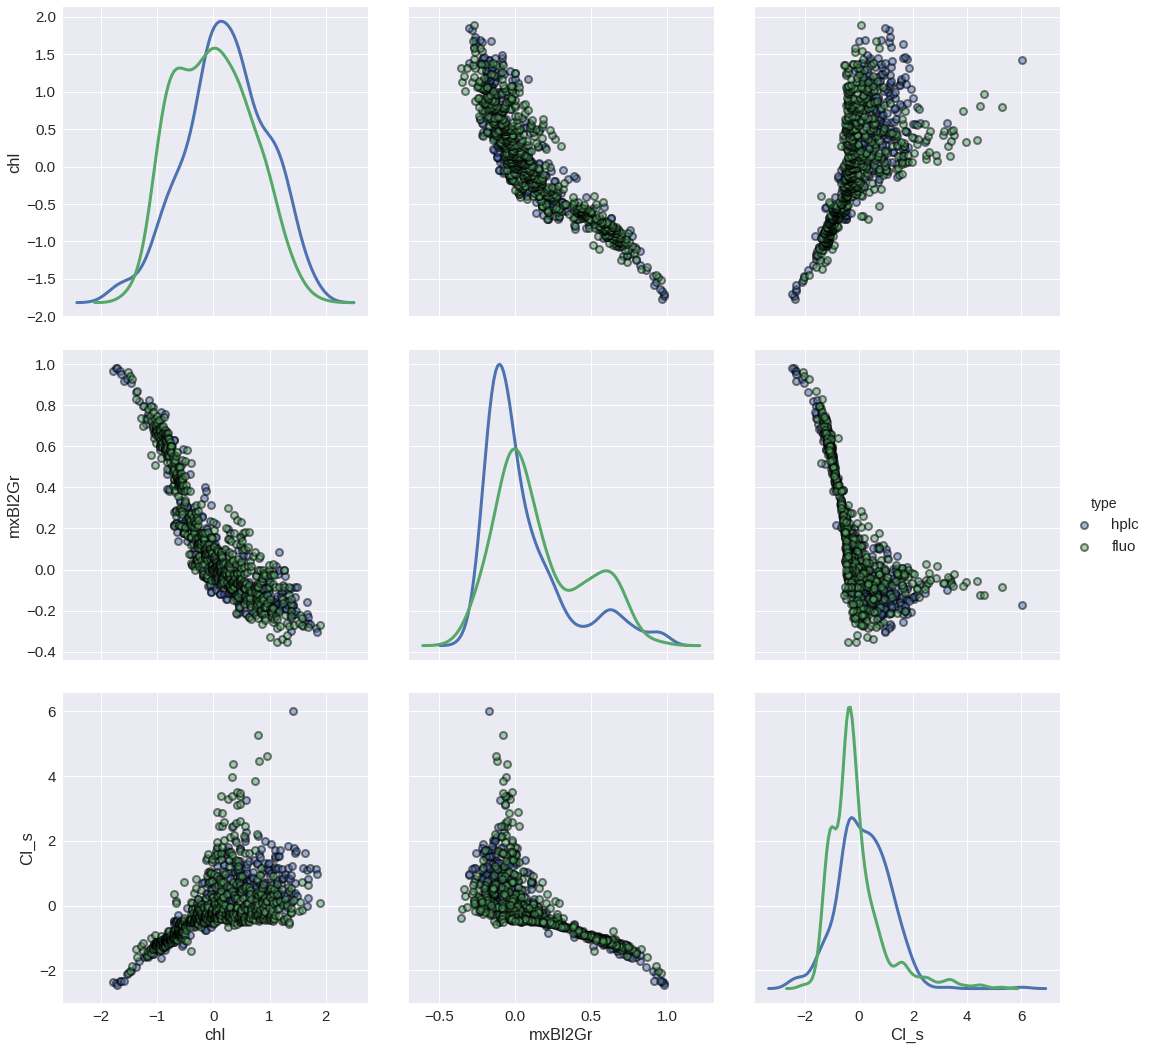

In [63]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfSortedLogOC4CI, vars=['chl', 'mxBl2Gr', 'CI_s'], hue='type', size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5, edgecolor='k', linewidth=2)
g = g.map_diag(sb.kdeplot, lw=3)
h = g.add_legend()
g = g.map_lower(pl.scatter, alpha=0.5, edgecolor='k', linewidth=2);

In [200]:
ocxRatio = dfSortedLogOC4CI.mxBl2Gr
chlObs = dfSortedLogOC4CI.chl
ocxRatioShrd = shared(ocxRatio.values)
ci = dfSortedLogOC4CI.CI
ciShrd = shared(ci.values)
ci_s_shr = shared(dfSortedLogOC4CI.CI_s.values)

In [201]:
idx = dfSortedLogOC4CI.index.values

In [108]:
with pm.Model() as model_OC4_4:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatioShrd + a2 * ocxRatioShrd**2 + a3 * ocxRatioShrd**3 + a4 * ocxRatioShrd ** 4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOC4_4 = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 203.732359
         Iterations: 19
         Function evaluations: 28


100%|██████████| 10500/10500 [00:41<00:00, 254.31it/s]

         Gradient evaluations: 28


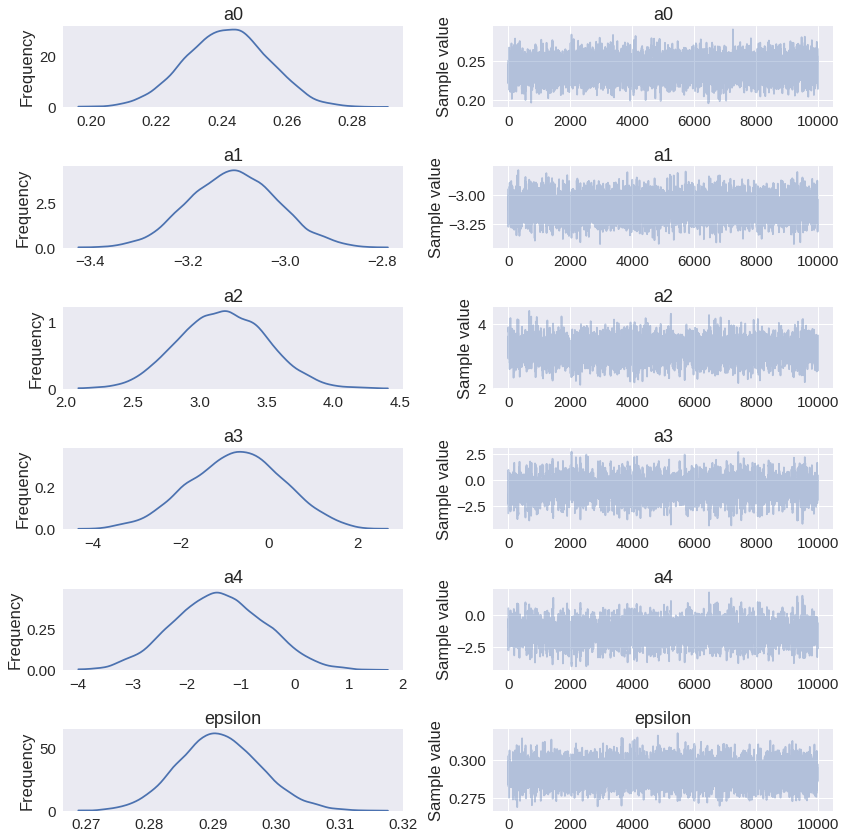

In [110]:
pm.traceplot(traceOC4_4, varnames=['a%d' %i for i in range(5)] + ['epsilon']);

In [80]:
with pm.Model() as model_OC4_3:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatioShrd + a2 * ocxRatioShrd**2 + a3 * ocxRatioShrd**3
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOC4_3 = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 201.870494
         Iterations: 20
         Function evaluations: 28


100%|██████████| 10500/10500 [00:18<00:00, 559.63it/s]

         Gradient evaluations: 28


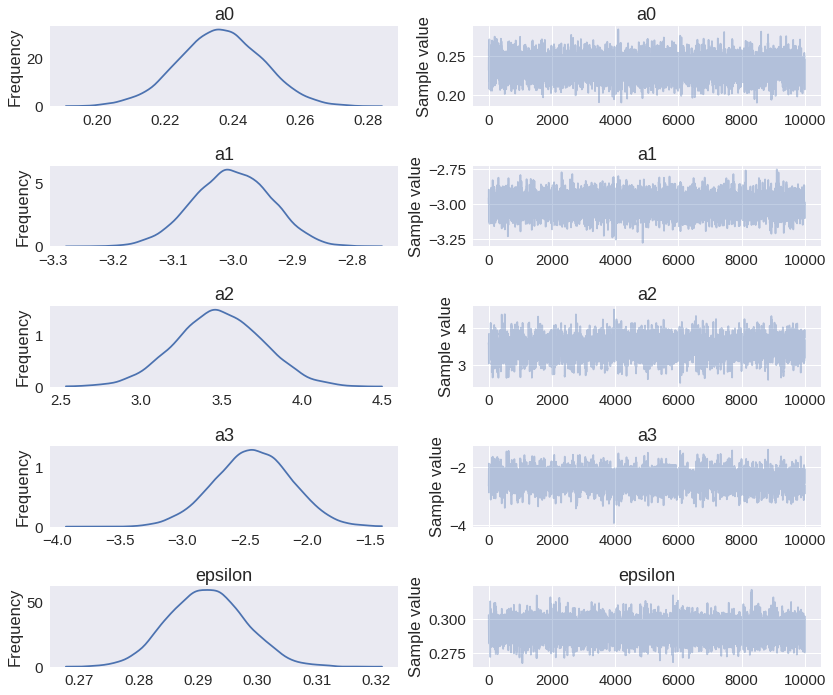

In [93]:
pm.traceplot(traceOC4_3, varnames=['a%d' %i for i in range(4)] + ['epsilon']);

In [64]:
with pm.Model() as mci:
    ci0 = pm.Normal('ci0', 0, 10)
    ci1 = pm.Normal('ci1', 0, 10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = ci0 + ci1 * ciShrd
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceCI = pm.sample(10000, step=step, start=start)

         Current function value: 911.636207
         Iterations: 16
         Function evaluations: 148
         Gradient evaluations: 136

100%|██████████| 10500/10500 [00:06<00:00, 1741.45it/s]

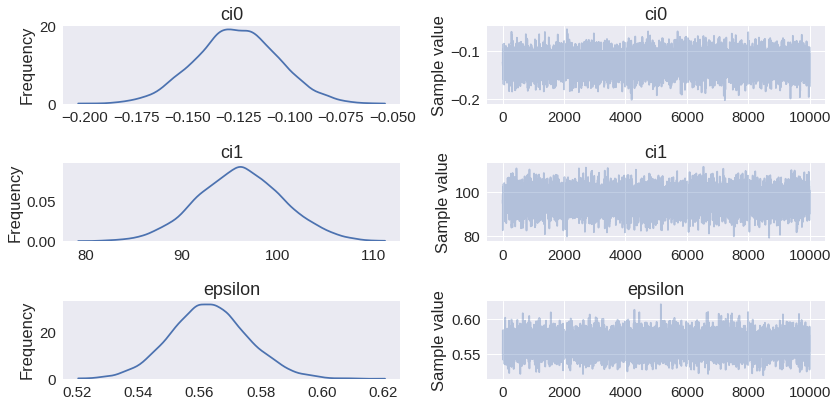

In [66]:
pm.traceplot(traceCI, varnames=['ci0', 'ci1', 'epsilon']);

In [68]:
with pm.Model() as mci_s:
    ci0 = pm.Normal('ci0', 0, 10)
    ci1 = pm.Normal('ci1', 0, 10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = ci0 + ci1 * ci_s_shr
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceCI_s = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 854.104129
         Iterations: 11
         Function evaluations: 20


100%|██████████| 10500/10500 [00:05<00:00, 1999.68it/s]

         Gradient evaluations: 20


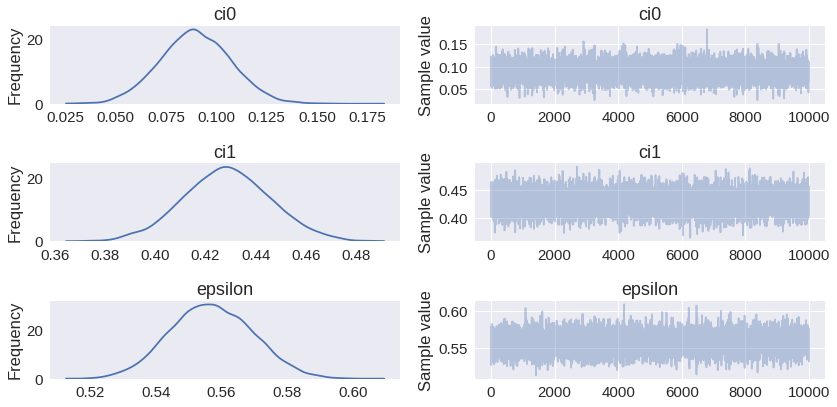

In [70]:
pm.traceplot(traceCI_s, varnames=['ci0', 'ci1', 'epsilon']);

In [206]:
with pm.Model() as oc4_ci_s:
    a_ci0 = pm.Normal('a_ci0', 0, 10)
    a_ci1 = pm.Normal('a_ci1', 0, 10)
    a_oc0 = pm.Normal('a_oc0', 0, 10)
    a_oc1 = pm.Normal('a_oc1', 0, 10)
    a_oc2 = pm.Normal('a_oc2', 0, 10)
    a_oc3 = pm.Normal('a_oc3', 0, 10)
    a_oc4 = pm.Normal('a_oc4', 0, 10)
    mu_ci_s  = a_ci0 + a_ci1 * ci_s_shr
    mu_oc = a_oc0 + ocxRatioShrd * (a_oc1 + a_oc2 * ocxRatioShrd +
                                    a_oc3 * ocxRatioShrd**2 + a_oc4 * ocxRatioShrd ** 3)
    sigma_ci = pm.HalfCauchy('sigma_ci', 5)
    sigma_oc = pm.HalfCauchy('sigma_oc', 5)
    nu_ci =  pm.Exponential('nu_ci', 4)
    nu_oc =  pm.Exponential('nu_oc', 4)
    switchpoint = pm.DiscreteUniform('switchpoint', idx.min(), idx.max())
    mu_ = pm.math.switch(idx >= switchpoint, mu_oc, mu_ci_s)
    sigma_ = pm.math.switch(idx >= switchpoint, sigma_oc, sigma_ci)
    nu_ = pm.math.switch(idx >= switchpoint, nu_oc, nu_ci)
    chlPredMix = pm.StudentT('chlPredMix', mu=mu_, sd=sigma_, nu=nu_, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_oc4_ci_s = pm.sample(10000, step=step, start=start)

         Current function value: 158.516322
         Iterations: 34
         Function evaluations: 110

Assigned Metropolis to switchpoint
100%|██████████| 10500/10500 [39:01<00:00,  5.29it/s] 


         Gradient evaluations: 98


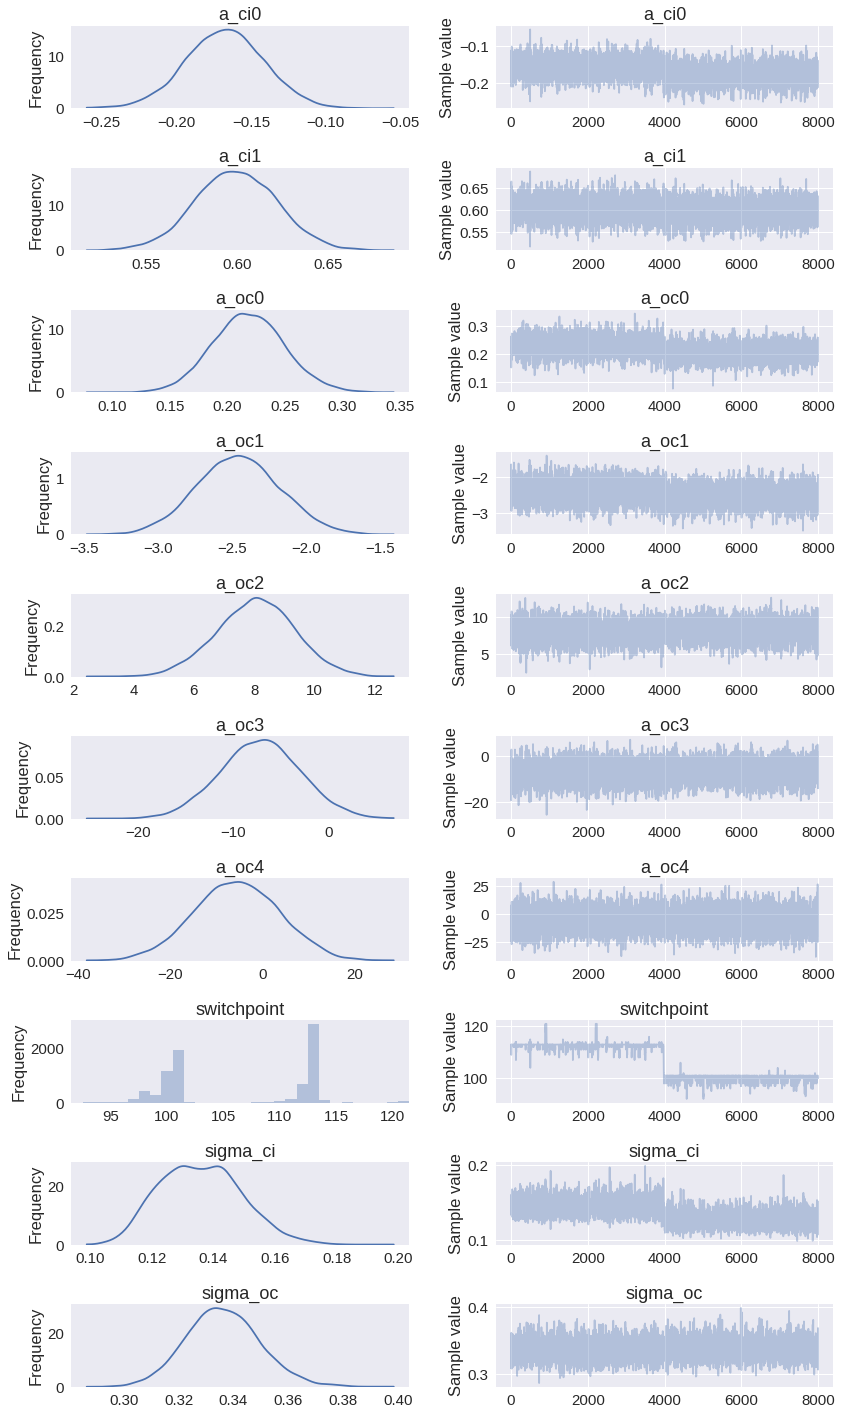

In [184]:
pm.traceplot(trace_oc4_ci_s[2000:]);

In [186]:
pm.coe

(10000,)

In [194]:
from scipy.stats import mode

In [195]:
mode(trace_oc4_ci_s['switchpoint'][2000:3000]), mode(trace_oc4_ci_s['switchpoint'][6000:])

(ModeResult(mode=array([113]), count=array([748])),
 ModeResult(mode=array([101]), count=array([1897])))

In [196]:
dfSortedLogOC4CI_hplc_only.loc[[101, 113]]

,id,mxBl2Gr,CI,type,chl,CI_s
101,2862,0.115845,0.004794,hplc,-0.199971,0.711372
113,2854,0.111424,0.004901,hplc,-0.166216,0.741391


In [1]:
import numpy as np

In [2]:
10**(-0.199971), 10**(-0.166216)

(0.630999478043207, 0.681999411653569)

In [133]:
with pm.Model() as OC4_ord3_robust:
    a0_3r = pm.Normal('a0_3r', mu=0, sd=10)
    a1_3r = pm.Normal('a1_3r', mu=0, sd=10)
    a2_3r = pm.Normal('a2_3r', mu=0, sd=10)
    a3_3r = pm.Normal('a3_3r', mu=0, sd=10)
    epsilon_3r = pm.HalfCauchy('epsilon_3r', 5)
    mu_3r = a0_3r + a1_3r * ocxRatioShrd + a2_3r * ocxRatioShrd**2 + a3_3r * ocxRatioShrd**3
    nu = pm.Deterministic('nu',pm.Exponential('nu_', 3) + 1)
    chlPred_3r = pm.StudentT('chlPred_3r', mu=mu_3r, sd=epsilon_3r, nu=nu, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord3_rob = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 158.699137
         Iterations: 23
         Function evaluations: 31

100%|██████████| 10500/10500 [01:46<00:00, 98.39it/s] 


         Gradient evaluations: 31


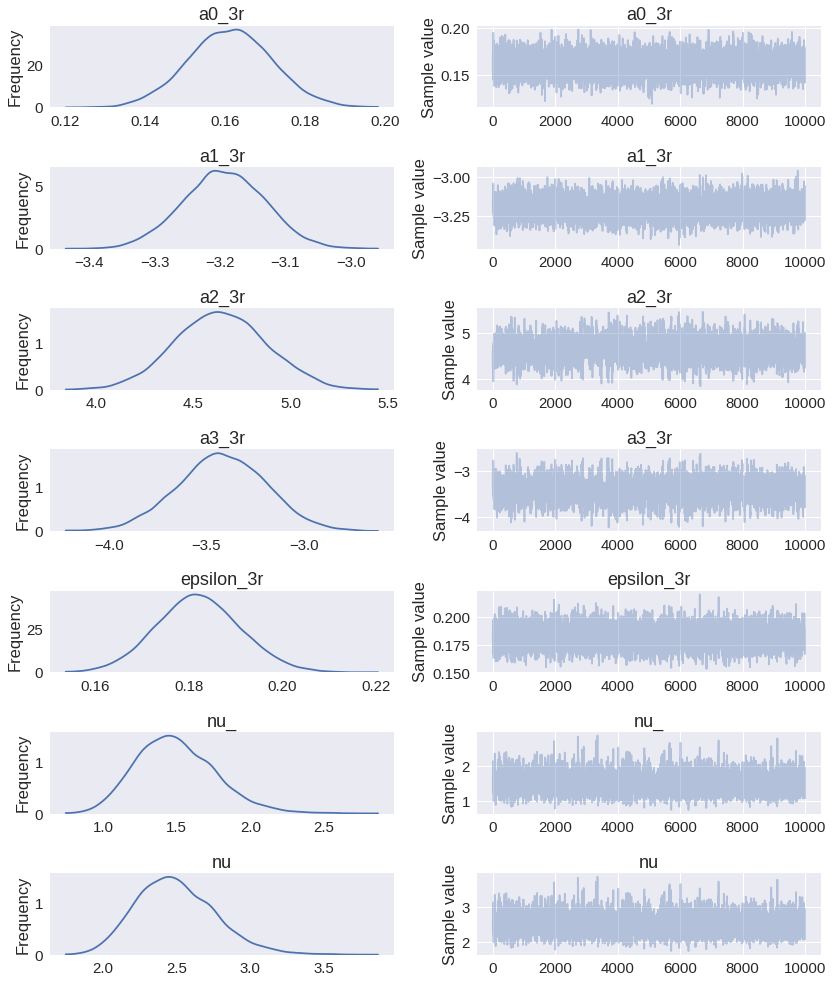

In [135]:
pm.traceplot(trace_ord3_rob);

In [137]:

with pm.Model() as OC4_ord4_robust:
    a0_4r = pm.Normal('a0_4r', mu=0, sd=10)
    a1_4r = pm.Normal('a1_4r', mu=0, sd=10)
    a2_4r = pm.Normal('a2_4r', mu=0, sd=10)
    a3_4r = pm.Normal('a3_4r', mu=0, sd=10)
    a4_4r = pm.Normal('a4_4r', mu=0, sd=10)
    epsilon_4r = pm.HalfCauchy('epsilon_4r', 5)
    mu_4r = a0_4r + a1_4r * ocxRatioShrd + a2_4r * ocxRatioShrd**2 + a3_4r * ocxRatioShrd**3 + a4_4r * ocxRatioShrd**4
    nu = pm.Deterministic('nu',pm.Exponential('nu_', 3) + 1)
    chlPred_4r = pm.StudentT('chlPred_4r', mu=mu_4r, sd=epsilon_4r, nu=nu, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord4_rob = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 161.829886
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


100%|██████████| 10500/10500 [04:03<00:00, 43.08it/s]


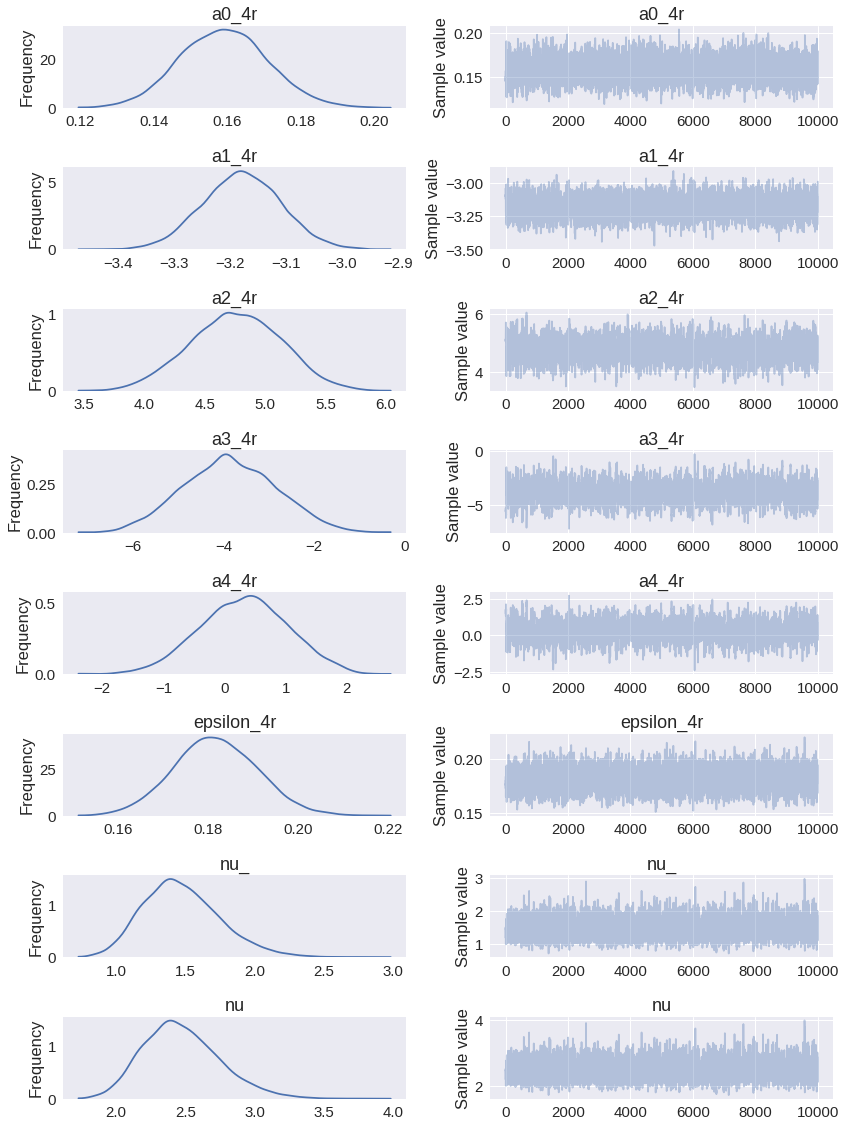

In [140]:
pm.traceplot(trace_ord4_rob);

In [199]:
traces = [traceOC4_4, traceOC4_3, traceCI, traceCI_s, trace_ord3_rob, trace_ord4_rob, trace_oc4_ci_s]
mdls = [model_OC4_4, model_OC4_3, mci, mci_s, OC4_ord3_robust, OC4_ord4_robust, oc4_ci_s]
mdlNms = ['model_OC4_4', 'model_OC4_3', 'mci', 'mci_s', 'model_OC4_3r', 'model_OC4_4r', 'oc4_ci_s']
dfMdlCmp = pm.compare(traces, mdls)
dfMdlCmp['name'] = [mdlNms[i] for i in dfMdlCmp.index.values]
dfMdlCmp.set_index('name', inplace=True)

ValueError: operands could not be broadcast together with shapes (417,) (1016,) 

In [ ]:
dfMdlCmp

In [113]:
tmp = dfMdlCmp.sort_index()
tmp['name'] = mdlNms
dfMdlCmp2 = tmp.sort_values('WAIC').set_index('name')

In [114]:
dfMdlCmp2

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
name,,,,,,,
model_OC4_4,379.537,5.55713,0,0.611341,56.4733,0,0
model_OC4_3,380.443,4.73207,0.905905,0.388659,56.5288,0.316593,0
mci_s,1696.54,4.04266,1317,6.34889e-287,44.0372,96.4544,0
mci,1718.18,3.08993,1338.64,1.269e-291,40.6829,92.2015,0


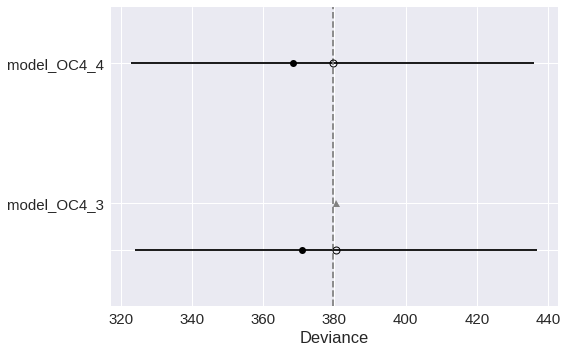

In [132]:
compare_plot(dfMdlCmp.loc[['model_OC4_4','model_OC4_3'], :])

In [131]:
dfMdlCmp.index

Index(['model_OC4_4', 'model_OC4_3', 'mci_s', 'mci'], dtype='object', name='name')